In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
PATH = "data/"
sz=224

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.backends.cudnn.enabled

True

In [10]:
print (torch.cuda.get_device_name(0))

Tesla K80


In [6]:
os.listdir(PATH)

['test', 'valid', 'train']

In [7]:
os.listdir(f'{PATH}valid')

['kali', 'ringo']

In [8]:
files = os.listdir(f'{PATH}valid/ringo')[:5]
files

['r00461.jpg', 'r00137.jpg', 'r00615.jpg', 'r00607.jpg', 'r00049.jpg']

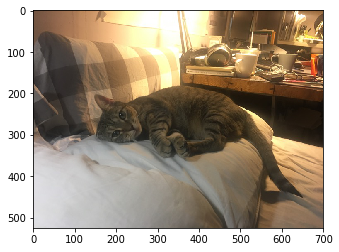

In [9]:
img = plt.imread(f'{PATH}valid/ringo/{files[0]}')
plt.imshow(img);

In [11]:
img.shape

(525, 700, 3)

In [12]:
img[:4,:4]

array([[[111,  82,  64],
        [111,  82,  64],
        [112,  83,  65],
        [112,  83,  65]],

       [[111,  82,  64],
        [111,  82,  64],
        [112,  83,  65],
        [112,  83,  65]],

       [[111,  82,  64],
        [111,  82,  64],
        [112,  83,  65],
        [112,  83,  65]],

       [[112,  83,  65],
        [112,  83,  65],
        [113,  84,  66],
        [113,  84,  66]]], dtype=uint8)

In [13]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 2)

100%|██████████| 4/4 [00:03<00:00,  1.16it/s]


epoch      trn_loss   val_loss   accuracy                 
    0      0.605844   0.412191   0.811594  
    1      0.450602   0.365193   0.855072                 



[array([0.36519]), 0.8550724646319514]

In [14]:
learn.fit(0.01, 5)

epoch      trn_loss   val_loss   accuracy                
    0      0.260311   0.353108   0.859903  
    1      0.237913   0.351064   0.869565                 
    2      0.224918   0.321612   0.874396                 
    3      0.2214     0.306451   0.884058                 
    4      0.203187   0.282921   0.888889                 



[array([0.28292]), 0.8888888897527243]

In [15]:
learn.precompute=False
learn.fit(0.01, 5)

epoch      trn_loss   val_loss   accuracy                  
    0      0.203115   0.305223   0.89372   
    1      0.201854   0.304395   0.89372                   
    2      0.213605   0.294206   0.898551                  
    3      0.203093   0.290805   0.903382                  
    4      0.194252   0.25537    0.913043                  



[array([0.25537]), 0.9130434788367598]

In [17]:
log_preds = learn.predict()
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

Correctly classified


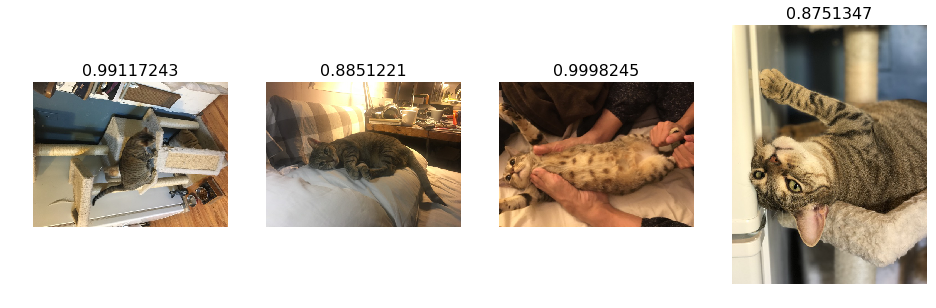

In [18]:
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


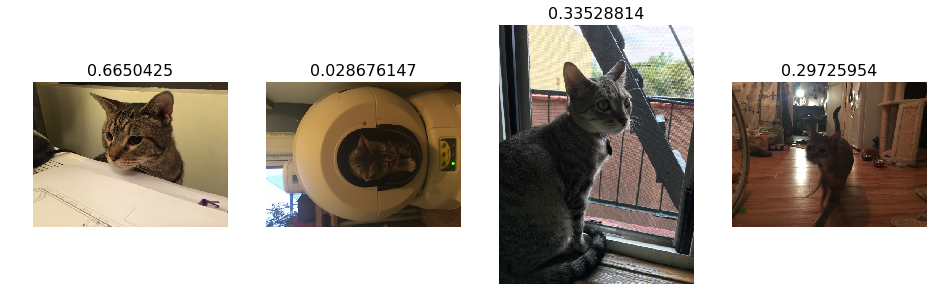

In [19]:
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [20]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct Kali


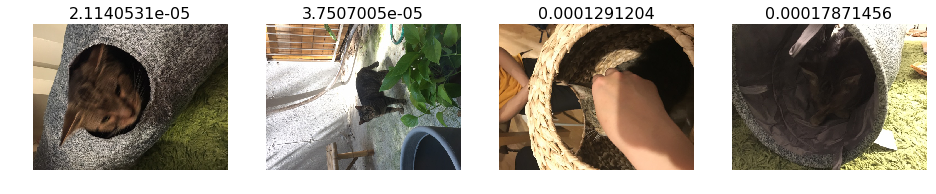

In [22]:
plot_val_with_title(most_by_correct(0, True), "Most correct Kali")

Most uncertain predictions


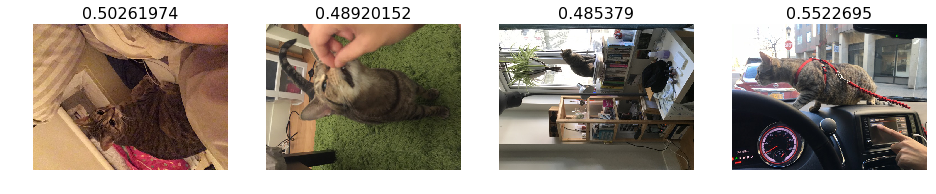

In [23]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

 95%|█████████▍| 18/19 [00:07<00:00,  2.36it/s, loss=0.414]


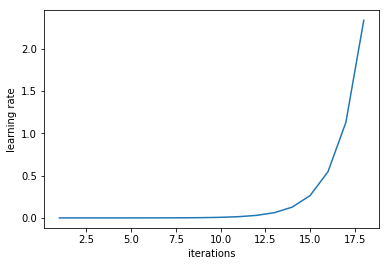

In [24]:
learn.lr_find()
learn.sched.plot_lr()

In [25]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [26]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=10, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

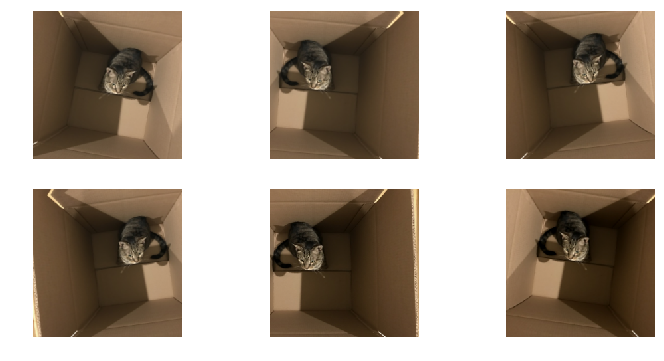

In [36]:
ims = np.stack([get_augs() for i in range(6)])
plots(ims, rows=2)

In [37]:
arch = resnet34
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, num_workers=-1)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [38]:
learn.lr_find()

epoch      trn_loss   val_loss   accuracy                 
    0      1.687308   809.609772 0.666667  



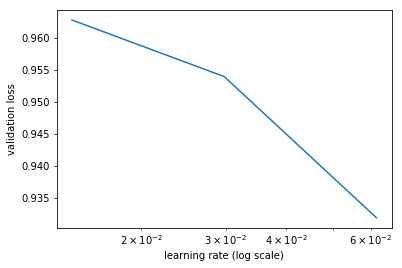

In [41]:
learn.sched.plot()

In [42]:
learn.fit(0.01, 2)

epoch      trn_loss   val_loss   accuracy                 
    0      0.615569   0.433775   0.821256  
    1      0.442519   0.387999   0.835749                



[array([0.388]), 0.835748793422312]

In [43]:
learn.precompute=False

In [44]:
learn.fit(0.01, 3)

epoch      trn_loss   val_loss   accuracy                  
    0      0.309075   0.34985    0.850242  
    1      0.29916    0.333881   0.850242                  
    2      0.275291   0.360337   0.835749                  



[array([0.36034]), 0.8357487939982022]

In [45]:
learn.fit(0.01, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                  
    0      0.257537   0.327324   0.884058  
    1      0.263877   0.326828   0.864734                  
    2      0.243439   0.325334   0.874396                  



[array([0.32533]), 0.874396136417481]

In [46]:
learn.unfreeze()

In [47]:
lr=np.array([1e-4,1e-3,1e-2])
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.364812   0.278574   0.879227  
    1      0.277895   0.250309   0.884058                  
    2      0.22834    0.225453   0.888889                  
    3      0.209055   0.251518   0.869565                  
    4      0.177497   0.205821   0.903382                  
    5      0.139074   0.188426   0.913043                  
    6      0.117303   0.203969   0.913043                  



[array([0.20397]), 0.9130434788367598]

In [48]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y)

0.9371980676328503

In [49]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

In [52]:
!ls

40301852_230075024352201_3698140113721622528_n.jpg  K_R_classifier.ipynb
40325456_259341704910733_1872169282184413184_n.jpg  README.md
data						    train_test_split.ipynb
fastai


In [55]:
img = plt.imread(f'40325456_259341704910733_1872169282184413184_n.jpg')

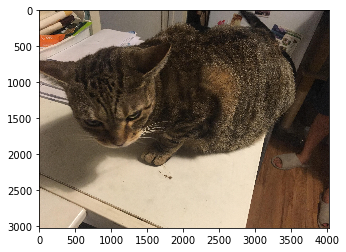

In [57]:
plt.imshow(img);

In [66]:
trn_tfms, val_tfms = tfms_from_model(arch,sz) # get transformations
im = val_tfms(open_image(f'40325456_259341704910733_1872169282184413184_n.jpg'))

In [73]:
im[None].shape

(1, 3, 224, 224)

In [74]:
learn.precompute=False # We'll pass in a raw image, not activations
log_preds = learn.predict_array(im[None])

In [75]:
probs = np.mean(np.exp(log_preds),0)

In [76]:
probs

array([0.87977, 0.12023], dtype=float32)

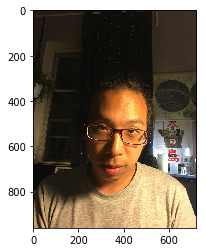

In [81]:
plt.imshow(plt.imread(f'40301852_230075024352201_3698140113721622528_n.jpg'))

In [79]:
leo = open_image(f'40301852_230075024352201_3698140113721622528_n.jpg')
leo = val_tfms(leo)
np.mean(np.exp(learn.predict_array(leo[None])),0)

array([0.17346, 0.82654], dtype=float32)